Use a trained model to predict the instances, that clearly had the wrong mask. Then use image similarity techniques to find the mask in the training set, that is "closest" to the prediction. Check if there was a mixup in the labels.

__Result:__ Not able to find the "correct" mask.

In [1]:
## Increase the width of the notebook cells

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Import Libraries

In [34]:
from fastai.vision.all import *
from assets.chiputility import *
from tqdm import tqdm

%matplotlib inline

### Setup paths

In [3]:
root_path = Path('data')
img_path = root_path / 'train_features'
label_path = root_path / 'train_labels'

### Load Dataframes

In [4]:
df_meta = pd.read_csv(root_path / 'train_w_meta.csv')
df_troubled = pd.read_csv(root_path / 'trouble_chips_final.csv', index_col = 0)
df_troubled = df_troubled[df_troubled['chip_id'].str.len() == 4] ## Remove broken chip names

In [5]:
df_meta.head(1)

,chip_id,location,datetime,cloudpath,is_valid,B02_path,B03_path,B04_path,B08_path,label_path,...,B04_min,B04_max,B04_range,B04_rel_range,B08_min,B08_max,B08_range,B08_rel_range,count_mask_pxl,pct_mask_pxl
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,False,data/train_features/adwp/B02.tif,data/train_features/adwp/B03.tif,data/train_features/adwp/B04.tif,data/train_features/adwp/B08.tif,data/train_labels/adwp.tif,...,556.0,8928.0,8372.0,0.937724,534.0,8488.0,7954.0,0.937088,125644.0,0.479


In [7]:
df_troubled.head(1)

,chip_id,problem
0,aehu,first 17 pixels in first row are zero instead of 1


### Reduce Datafrarme to chips, that specifically have a wrong mask, which is likely to be a mixup

In [9]:
df_troubled = df_troubled[df_troubled['problem'] == 'wrong mask']

In [10]:
df_troubled

,chip_id,problem
154,cmzm,wrong mask
155,cnzb,wrong mask
157,coib,wrong mask
159,cooi,wrong mask
161,cozi,wrong mask
...,...,...
1905,zbli,wrong mask
1906,zbpo,wrong mask
1918,zvue,wrong mask
1921,zwdz,wrong mask


### Include metadata 
`df_meta[df_meta['chip_id'].isin(df_troubled['chip_id'].unique())]` should be easier

In [20]:
df = df_troubled.merge(df_meta, how='left', on = 'chip_id')
df = df[[col for col in df.columns if 'path' not in col]]
df.drop_duplicates('chip_id', inplace=True) ## Some chips have to individual problems assigned

In [11]:
import xarray
import xrspatial.multispectral as ms

def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])

def true_color_img(chip):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    red = get_xarray(chip / "B04.tif")
    green = get_xarray(chip / "B03.tif")
    blue = get_xarray(chip / "B02.tif")

    return ms.true_color(r=red, g=green, b=blue)

## Variation of `display_chip` in "Remove bad Data from Dataset.ipynb"
def plot_img_mask(img_id, mask_id, n_turns = False, smooth = False):
    img_loc = df.loc[df['chip_id'] == img_id, 'location'].item()
    mask_loc = df_meta.loc[df_meta['chip_id'] == mask_id, 'location'].item()
    
    img = np.asarray(true_color_img(img_path / img_id))
    msk = get_mask(img_path / mask_id, label_path)
    
    if n_turns:
        for _ in range(n_turns):
            msk = np.rot90(msk)
    if smooth:
        pil_msk = Image.fromarray(msk)
        pil_msk_smooth = pil_msk.filter(ImageFilter.ModeFilter(size=5))
        msk = np.array(pil_msk_smooth)
    contour = np.array(Image.fromarray(msk).filter(ImageFilter.FIND_EDGES))
    img[np.where(contour)] = (250.,50.,150.,255.)
    
    fig, ax = plt.subplots(1, 2, figsize=(25, 10))
    ax[0].imshow(img)
    ax[0].set_title(f"Chip {img_id}\n(Location: {img_loc})")
    ax[0].axis('off')
    
    ax[1].imshow(msk)
    ax[1].set_title(f"Chip {mask_id} label; min: {msk.min()}, max: {msk.max()}, mean: {msk.mean()}")
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()

## Predict masks of bad instances

In [13]:
from fastai.vision.all import *
from tqdm import tqdm
import albumentations as A
from functools import partial
from assets.chiputility import *

Hyperparameters, the model has been trained on

In [14]:
IMG_SIZE = 512
BS = 2

### Add the augmentation code to load model

In [15]:
class OnlyVizAlbumentationsTransform(Transform):
    split_idx = 0
    def __init__(self, aug):
        self.aug = aug
    def encodes(self, x):
        if len(x.shape) > 2:
            non_viz_channels = x[...,3:]
            viz_aug = self.aug(image=x[...,:3].astype(np.float32))['image']
            return np.concatenate([viz_aug,non_viz_channels], axis = -1)
        else:
            return x

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        augs = []
        for img,mask in x:
            augs.append(tuple(self.aug(image=img, mask=mask).values()))
        return augs

class TransposeTransform(ItemTransform):
    def encodes(self, x):
        transposed = []
        for img, mask in x:
            transposed.append((TensorImage(img.transpose(2,0,1)).float(), TensorMask(mask).long()))
        return transposed

class FormatTransform(ItemTransform):
    def __init__(self, return_type):
        self.return_type = return_type
    def encodes(self, x):
        return self.return_type([TensorImage(x[0].permute(0,3,1,2)).float(), TensorMask(x[1]).long()])

viz_augs_list = A.Compose([
    A.HueSaturationValue(
        hue_shift_limit=0.1,
        sat_shift_limit=0.1,
        val_shift_limit=0.1,
        p = 0.5
    ),
    #A.Normalize(max_pixel_value = 1),
    A.RandomBrightnessContrast(),
])
    
geom_augs_list = A.Compose([
     A.Flip(),
     #A.RandomCrop(440, 440),
     #A.RandomGridShuffle(grid = (2,2), p = 0.3),
     A.CoarseDropout(mask_fill_value = 0),
    ])

viz_augs_tfms = OnlyVizAlbumentationsTransform(viz_augs_list)
geom_augs_tfms = SegmentationAlbumentationsTransform(geom_augs_list)
transpose_tfm = TransposeTransform()
format_tfm = FormatTransform(tuple)

### Load pretrained model

In [16]:
learn = load_learner('models/test_learner', cpu = True)
learn.dls.loaders[0].before_batch = Pipeline(transpose_tfm) ## Workaround to apply permutation of dimensions

In [21]:
chips = Chips(img_path, df, debug = False)

### Create dataloaders for selected (bad) instances

In [22]:
test_dl = learn.dls.test_dl(chips.paths, bs = 1, with_labels = True)

In [39]:
test_iters = iter(test_dl)

### Display predicted mask, original image and original (ground truth) mask

In [46]:
def compare_preds(img, pred, msk):
    fig, axs = plt.subplots(1,3,figsize=(30,20))
    axs[0].imshow(pred)
    axs[0].set_title('Predicted Mask')
    axs[0].axis('off')
    
    axs[1].imshow(img)
    axs[1].set_title('Image')
    axs[1].axis('off')
    
    axs[2].imshow(msk)
    axs[2].set_title('Original Mask')
    axs[2].axis('off')
    
    plt.show()

### Check sample

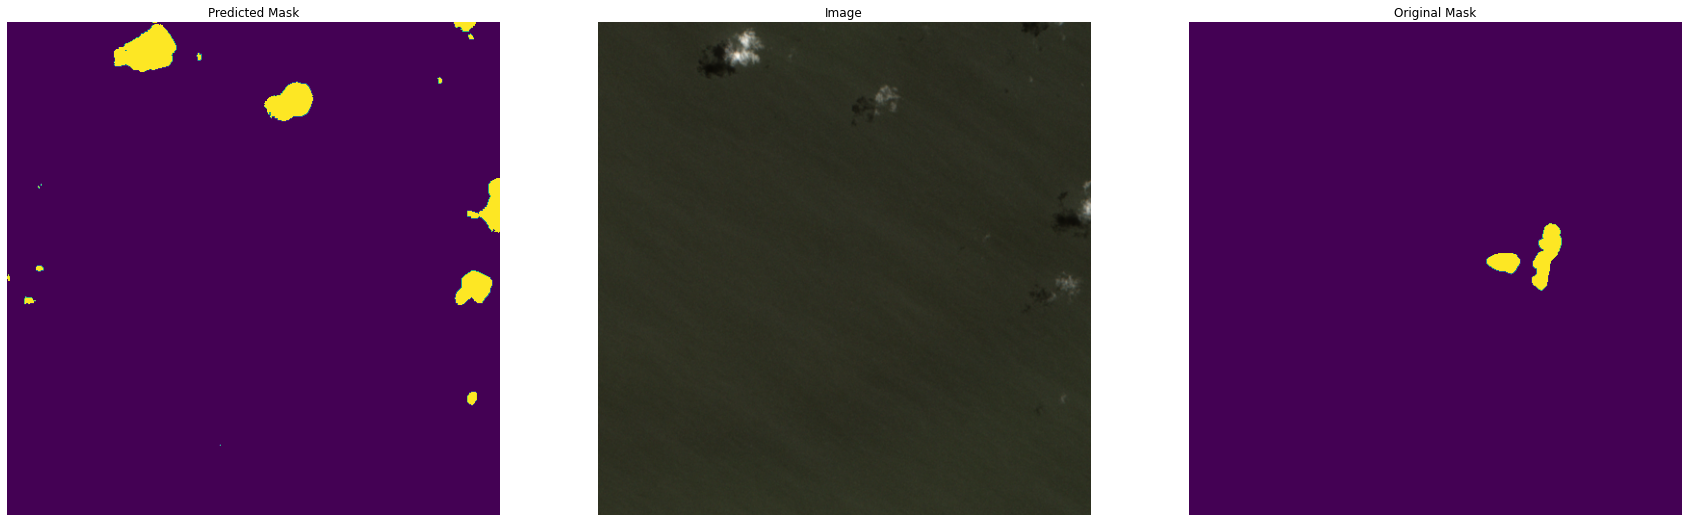

In [81]:
b = next(test_iters)
pred = learn.model(b[0])
msk = pred[0].argmax(dim=0)
img = b[0][0,:3,...].permute(1,2,0).detach()

compare_preds(img,msk,b[1][0])

### The goal is to compare the predicted masks to all ground truth masks and find the one, that is most "similar". It might be possible to find the acctual mask of the instance and refeed the results to the dataset.

In [23]:
### Create a tmp folder to save predicted masks
trouble_path = Path('data/trouble_masks')
trouble_path.mkdir(exist_ok = True)

### Predict masks for the instances and save as binary image

In [24]:
for i, b in enumerate(test_dl):
    pred = learn.model(b[0])
    msk = pred[0].argmax(dim = 0)
    img = Image.fromarray(msk.numpy().astype(np.uint8))
    
    chip_id = chips.paths[i].stem
    fn = (trouble_path / chip_id).with_suffix('.tif')
    
    img.save(fn)

### Load "ground truth" and predicted mask paths

In [25]:
orig_mask_paths = get_image_files(label_path)
trouble_mask_paths = get_image_files(trouble_path)

### Create Dataframe to save "similarity" values

In [26]:
diff_df = pd.DataFrame(index = orig_mask_paths.attrgot('stem'), columns = trouble_mask_paths.attrgot('stem'))

In [27]:
import imagehash ## Used to calc different similarity values

### Check sample

In [28]:
trouble_maker = trouble_mask_paths[2]
anker_hash = imagehash.dhash(Image.open(trouble_maker))

### Get the similarity of the `trouble_maker` mask and all ground truth masks

In [29]:
for fn in tqdm(orig_mask_paths):
    #other_hash = imagehash.dhash(Image.open(fn))
    #diff_df.loc[fn.stem, trouble_maker.stem] = anker_hash - other_hash
    acc = np.logical_and(np.array(Image.open(trouble_maker)), np.array(Image.open(fn))).sum() / (512*512)
    diff_df.loc[fn.stem, trouble_maker.stem] = acc

100%|██████████| 11748/11748 [00:37<00:00, 314.61it/s]


### Get all chips that have a similarity below a certain threshold

In [30]:
trouble_chip = trouble_maker.stem
tmp_df = diff_df[diff_df[trouble_chip] < 0.28]
tmp_df[tmp_df[trouble_chip] == tmp_df[trouble_chip].max()]

,utdl,hyou,zafv,khkb,gqtt,grtm,cwbs,hyfv,kgsm,gspj,...,jalp,iayu,csxg,cutq,gsvw,khlo,ibtq,dfwk,rcaw,gszw
amog,NaN,NaN,0.27993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


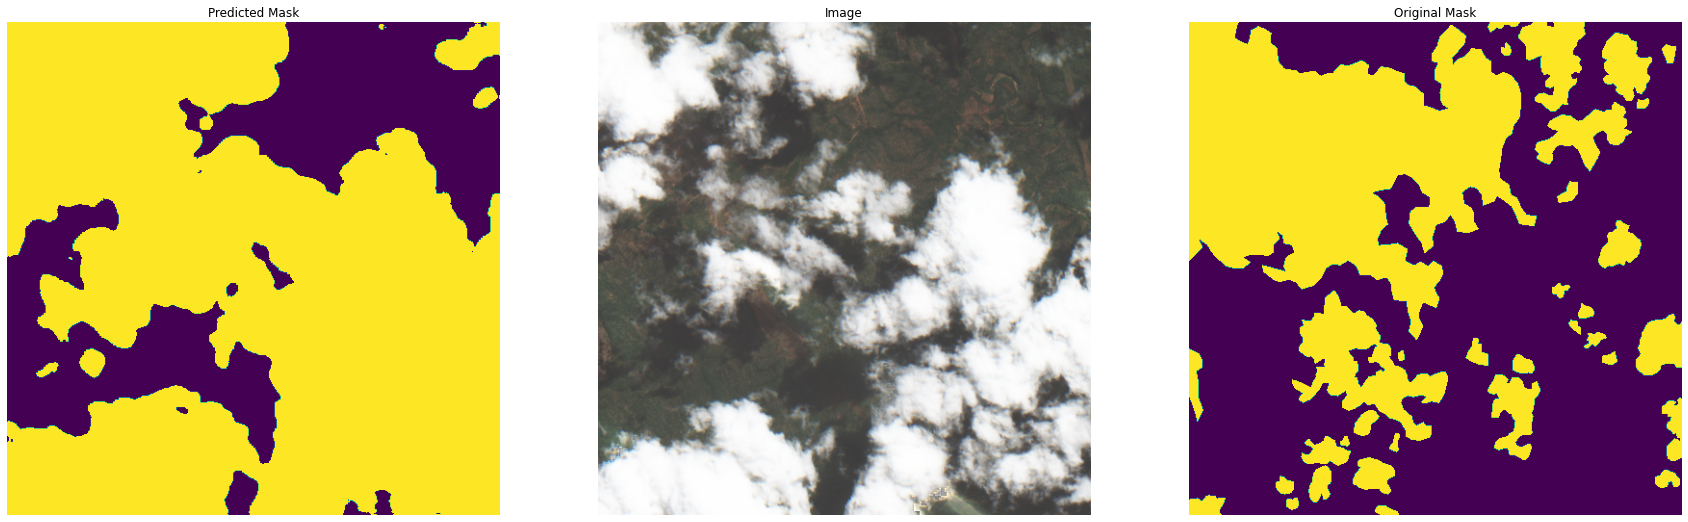

In [47]:
trouble_chip = 'zafv'
similar_chip = 'amog'

img = np.array(true_color_img(img_path / trouble_chip))
pred = np.array(Image.open((trouble_path / trouble_chip).with_suffix('.tif')))
mask = np.array(Image.open((label_path / similar_chip).with_suffix('.tif')))
compare_preds(img,pred,mask)

## Result:
Unfortunately this method doesn't find the correct mask for all tested chips.